Training Hands: 2000
Training Hands: 4000
Training Hands: 6000
Training Hands: 8000
Training Hands: 10000
Training Hands: 12000
Training Hands: 14000
Training Hands: 16000
Training Hands: 18000
Training Hands: 20000


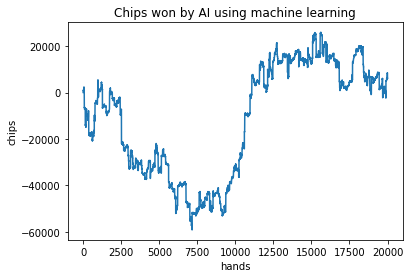

In [18]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
from hups_utilities import *
import random
import numpy as np
from deepNeuralNetwork import *
from collections import OrderedDict
from collections import Counter
from dnn_app_utils_v2 import *
from game import *

class Player:
    isAI = True
    AIlevel = 1
    chips = 0
    hands = 0
    neuralParameters = None
    raisePercent = 1./3
    callPercent = 2./3
    hand = []
    handWon = None
    handsPlayed = 0.0
    playerNumber = -1

    #These are for the GTO AI using ranges
    preflopHandOdds = []  #This is set based on how good a particular hand is vs another random hand
    currentRange = []     #This starts as the above ordered dictionary every hand

    #These are for keeping track of what hands win instead of loading stored info into preflopHandOdds
    preflopHandsWon = []
    preflopHandsPlayed = []

    #These are for updating and keeping track of relevant information for each state
    #Each state is built upon [number of previous raises (7), card rank (13), card rank(13)]
    #The outputs describe how opponent will react to a raise:
    #[odds opponent re-raises, odds opponent folds, odds your opponent calls, odds you win if you call the raise, EV of hand]
    state_num = np.full([16, 13, 13, 5], [.3, .3, .4, .5, .25])
    state_denom = np.full([16, 13, 13, 5], [1, 1, 1, 1, 1])

    #This will track all decisions played on a hand and be reset at the end of each hand
    decision_text = ""
    #This will track overall decisions being made [Raise, Check/Call, Fold, Total]
    decision_results = [0., 0., 0., 0.]


    #This stores all the state information for the previous hand
    hand_info = []

    #This parameter determines how often we take a random action
    alpha = .4
    #This is the decay factor for future decisions
    epsilon = .5

    decisions = ['Fold', 'Call', 'Check', 'Bet', 'Raise']
    aiType = {1 : 'Calling Station', 2 : 'GTO', 3 : 'Neural'}

    def __init__(self, isAI = True, AIlevel = 1):
        self.isAI = isAI
        self.AIlevel = AIlevel
        if isAI:
            self.preflopHandOdds = OrderedDict(createPreflopOrderedRange(np.loadtxt("data", unpack=True)))
            self.currentRange = self.preflopHandOdds
    '''
    def resetStatisticalData(self):
        self.handsPlayed = 0
        self.preflopHandsWon = []
        self.preflopHandsPlayed = []
        for x in range(13):
            self.preflopHandsWon.append([])
            self.preflopHandsPlayed.append([])
            for y in range(13):
                self.preflopHandsWon[x].append(1.0 + (random.random()/100))
                self.preflopHandsPlayed[x].append(2.0)

    def getHandPercentages(self):
        preflopHandPercentage = [[[self.preflopHandsWon[y][x][z]/self.preflopHandsPlayed[y][x][z] for x in range(13)] for y in range(13)] for z in range(len(self.preflopHandsWon[y][x]))]
        return preflopHandPercentage
    '''
    def handStart(self):
        self.decision_text = ''        

    def handOver(self, hand_info, percentWon):
        self.hands += 1
        self.handWon = hand_info['Winner']
        self.hand_info = hand_info
        self.currentRange = self.preflopHandOdds
        '''
        if self.AIlevel == 2:
            self.updateHandRange(hand_info)
        '''
        if self.AIlevel == 3:
            betting = hand_info['Betting']
            raise_count = betting.count('Bet') + betting.count('Raise')
            hand = self.hand

            #This tracks how often a particular hand won at showdown which is why we ignore this if the hand ended with a fold
            if not 'Fold' in betting:
                self.state_num[raise_count][14 - hand[0].value][14 - hand[1].value][3] += self.handWon
                self.state_denom[raise_count][14 - hand[0].value][14 - hand[1].value][3] += 1

            otherPlayerNum = (self.playerNumber + 1) % 2
            otherPlayerBets = hand_info['Player Bets'][otherPlayerNum]

            actions = ['Bet', 'Fold', 'Call', 'Raise']

            for bet in otherPlayerBets:
                for x in range(len(actions)):
                    if bet[1] == actions[x]:
                        self.state_num[bet[0]][0][0][x%3] += 1
                        self.state_denom[bet[0]][0][0] += [1, 1, 1, 0, 0]



    def getChips(self, amount, outputDict):
        self.chips += amount

    def generateHandAbbreviation(self):
        suited = 'o'
        if self.hand[0].suit == self.hand[1].suit:
            suited = 's'
        return self.hand[0].rank + self.hand[1].rank + suited

    def decideLevel1(self, previousAction, raiseAmount = 0):
        if previousAction == None:
            if raiseAmount > 0: return 'Call'
            else: return 'Check'
        elif previousAction == 'Bet' or previousAction == 'Raise': return 'Call'
        elif previousAction == 'Call' or previousAction == 'Check': return 'Check'

    #This uses a range of starting hands to determine what hands to raise/call/fold with
    def decideLevel2(self, previousAction, raiseAmount):
        n = len(self.currentRange)
        #print self.currentRange
        odds = self.currentRange[self.generateHandAbbreviation()]

        if previousAction in ['Call', 'Check', None]:
            if odds > self.currentRange.values()[int(self.raisePercent * n)]: 
                self.currentRange = OrderedDict(self.currentRange.items()[:int(self.raisePercent * n)])
                return 'Bet'
            elif raiseAmount > 0: return 'Call' 
            else: return 'Check'
        elif previousAction == 'Bet' or previousAction == 'Raise':
            if odds > self.currentRange.values()[int(self.raisePercent * self.callPercent * n)]: 
                self.currentRange = OrderedDict(self.currentRange.items()[:int(self.raisePercent * self.callPercent * n)])
                return 'Raise'
            elif odds > self.currentRange.values()[int(self.callPercent * n)]:
                self.currentRange = OrderedDict(self.currentRange.items()[:int(self.callPercent * n)])
                return 'Call'
            else:
                return 'Fold'
        assert False

    def decideLevel3(self, previousAction, bets, raiseAmount):

        if random.random() < self.alpha:
            #print "Taking random action"
            if raiseAmount > 0:
                return random.choice(['Call', 'Raise'])
            else:
                return random.choice(['Check', 'Raise'])


        card0 = 14 - self.hand[0].value
        card1 = 14 - self.hand[1].value


        #EV of folding LOL
        fold_EV = 0

        #Size of the pot, cost of calling
        pot, call_cost = 1.0, raiseAmount
        #Odds of winning after calling
        call_odds = self.state_num[bets][card0][card1][3]/self.state_denom[bets][card0][card1][3]
        #call cost times odds of winning hand with n bets
        call_EV = ((pot + call_cost) * call_odds) - call_cost

        self.decision_text += "\nOdds of you winning the hand if you call: " + str(call_odds) 
        self.decision_text += "\nCost of calling: " + str(call_cost)
        self.decision_text += "\nValue of state if you call: " + str(call_EV) + "\n"        

        #Cost of placing a raise, pot size after raise
        raise_cost = 2 * call_cost + pot
        raise_pot = pot + raise_cost
        #Odds of opponent folding
        odds_of_fold = self.state_num[bets+1][0][0][1]/self.state_denom[bets+1][0][0][1]
        #EV gained by opponent folding to a raise
        raise_fold_EV = odds_of_fold * raise_pot

        self.decision_text += "\nCost of raising: " + str(raise_cost) + "\n"
        self.decision_text += "\nOdds of opponent folding: " + str(odds_of_fold)
        self.decision_text += "\nValue of raise -> fold state: " + str(raise_fold_EV) + "\n"

        #Pot after raise and call
        raise_call_pot = raise_pot + raise_cost
        #Odds of opponent calling
        odds_of_call = self.state_num[bets+1][0][0][2]/self.state_denom[bets+1][0][0][2]
        #Odds of winning hand if opponent calls a raise
        odds_with_raise = self.state_num[bets + 1][card0][card1][3]/self.state_denom[bets + 1][card0][card1][3]
        #EV of winning hand when opponent calls a raise
        raise_call_EV = round(odds_with_raise * odds_of_call * raise_call_pot, 4)

        self.decision_text += "\nOdds of opponent calling: " + str(odds_of_call)
        self.decision_text += "\nOdds of winning hand if opponent calls: " + str(odds_with_raise)
        self.decision_text += "\nRaise + Call Pot: " + str(raise_call_pot)
        self.decision_text += "\nValue of raise -> call state: " + str(raise_call_EV) + "\n"        

        #Pot after raise and raise
        raise_raise_pot = raise_call_pot * 2
        #Odds of opponent raising
        odds_of_raise = self.state_num[bets+1][0][0][0]/self.state_denom[bets+1][0][0][0]
        #EV of the state after opponent re-raises you        #only use the numerator for State EV
        reraise_EV = self.state_num[bets+2][card0][card1][4] #self.state_denom[bets+2][card0][card1][4] 
        #EV of getting to the state after a re-raise
        raise_raise_EV = raise_raise_pot * odds_of_raise * reraise_EV

        self.decision_text += "\nOdds of opponent reraising: " + str(odds_of_raise)
        self.decision_text += "\nValue of state after opponent reraises: " + str(reraise_EV)
        self.decision_text += "\nValue of opponent reraising you: " + str(raise_raise_EV)        

        #Total EV of raising
        raise_EV = round(self.epsilon * ((-raise_cost) + raise_fold_EV + raise_call_EV + raise_raise_EV), 4)

        self.decision_text += "\nValue of raising opponent: " + str(raise_EV) + "\n" 

        # ['Fold', 'Call', 'Raise']
        # [fold_EV, call_EV, raise_EV]
        d = {'Raise': raise_EV, 'Fold': fold_EV, 'Call': call_EV}
        options_EV = OrderedDict(sorted(d.items(), key = lambda t: -t[1]))
        optimal = options_EV.items()[0]


        self.decision_text += str(options_EV) + "\n"

        self.state_num[bets][card0][card1][4] = options_EV.items()[0][1]

        #This tracks what % of the time our AI decides to raise/call/fold
        if options_EV.items()[0][0] == 'Raise':
            self.decision_results[0] += 1
        elif options_EV.items()[0][0] == 'Call':
            self.decision_results[1] += 1
        else:
            self.decision_results[2] += 1
        self.decision_results[3]+=1    

        return options_EV.items()[0][0]



    def updateHandRange(self, handInfo):
        if self.AIlevel == 2:
            assert self.handWon != None
            hand = self.hand
            preflopHandsWon = []
            preflopHandsPlayed = []
        #The neural network needs to be updated to work with our increased number of variables
        '''
        if self.AIlevel == 3:
            currentHandPercentages = np.array(self.game.getHandPercentages()).reshape(1,169)
            overallHandPercentages = np.loadtxt("data", unpack=True).reshape(1, 169)

            train_x = currentHandPercentages
            train_y = overallHandPercentages

            n_x = train_x.shape[0]
            n_y = train_y.shape[0]
            layers_dims = [n_x, 50, 12, 5, n_y] #  This determines how many hidden layers the network will use

            parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = .2, num_iterations = 100, print_cost = False, plotGraph = False, params = self.neuralParameters)
            self.neuralParameters = parameters

            AL, caches = L_model_forward(currentHandPercentages, parameters)

            self.preflopHandOdds = OrderedDict(createPreflopOrderedRange(AL.reshape(13, 13)))
            '''
    def decide(self, previousAction, number_bets , raiseAmount):
        if self.isAI:
            if self.AIlevel == 1: return self.decideLevel1(previousAction, raiseAmount)
            elif self.AIlevel in [2]: return self.decideLevel2(previousAction, raiseAmount)
            elif self.AIlevel in [3]: return self.decideLevel3(previousAction, number_bets ,raiseAmount)

def runHands(poker, hands = 10000):
    milestone = hands/10

    for x in range(1, hands + 1):
        poker['game'].nextHand()
        poker['neural_chips'].append(poker['p1'].chips)

        if x % milestone == 0:
            print('Training Hands: ' + str(x))

    #print(Player1.decision_text)
    plt.plot(poker['neural_chips'])
    plt.xlabel('hands')
    plt.ylabel('chips')
    plt.title('Chips won by AI using machine learning')
    plt.show()

    #This shows what percentage of the time our AI [Raised, Call, Folded]
    #print [poker['p1'].decision_results[x] / poker['p1'].decision_results[3] for x in range(3)]

def newNeuralTest():
    Player0 = Player(True, 2)
    Player1 = Player(True, 3)
    game = Game([Player0,Player1])
    neural_chips = []
    hands = 20000

    poker = {'p0': Player0, 'p1': Player1, 'game': game, 'neural_chips': neural_chips}

    Player1.alpha = 0
    Player1.epsilon = 1
    game.output = False

    runHands(poker, hands)

if __name__ == "__main__":
    newNeuralTest()


In [14]:
print game.handDict['Text']
print Player1.decision_text

NameError: name 'game' is not defined